In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

class inventory_model:
    '''Small class to hold model fundamentals and its solution'''

    def __init__(self,label='noname',
                 max_inventory=10,  # upper bound on the state space
                 c = 3.2,            # fixed cost of order
                 p = 2.5,           # profit per unit of good
                 r = 0.5,           # storage cost per unit of good
                 β = 0.95,          # discount factor
                 pr = 0.12
                 ):
        '''Create model with default parameters'''
        self.label=label # label for the model instance
        self.c, self.p, self.r, self.β = c, p, r, β
        # created dependent attributes (it would be better to have them updated when underlying parameters change)
        self.n = max_inventory+1    # number of inventory levels
        self.pr = pr
    

    def demand_pr(self):
        a = []
        for i in range(self.n-1):
          a += [((1-self.pr)**i)*self.pr]
        a += [1-sum(a)]
        return a
    def plot_pr(self):
      fig1, (ax1) = plt.subplots(1,figsize=(14,8))
      ax1.grid(b=True, which='both', color='0.65', linestyle='-')
      ax1.set_xlabel('Demand')
      ax1.set_title('Probability')
      ax1.plot(np.arange(self.n),self.demand_pr(),color='r',linewidth=2.5)
      plt.show

    def bellman(self, ev0):
      prob = self.demand_pr()
      ev1 = []
      qfinal = []
      for l in range(self.n):
        a = []
        for q in range(self.n-l):
          a += [-self.r*(l+q)-self.c*(q>0)+self.β*ev0[l+q]]
        t = max(a)
        qfinal += [a.index(t)]
      for x in range(self.n):
        s = 0
        for d in range(self.n):
          left = np.maximum(x-d,0)
          s += (self.p*np.minimum(x,d)-self.r*(left+qfinal[left])-self.c*(qfinal[left]>0)+self.β*ev0[left+qfinal[left]])*prob[d]
        ev1 += [s]
      return np.array(ev1), np.array(qfinal)
    def solve_vfi(self,tol=1e-6,maxiter=1000,callback=None):
        '''Solves the Rust model using value function iterations
        '''
        ev0 = [7, 10, 11, 15, 21, 23, 25, 28, 29, 30, 32] # initial point for VFI
        for i in range(maxiter):  # main loop
            ev1, qfinal = self.bellman(ev0)  # update approximation
            err = np.amax(np.abs(ev0-ev1))
            if callback != None: callback(iter=i,err=err,ev1=ev1,ev0=ev0,qfinal=qfinal,model=self)
            if err<tol:
                break  # break out if converged
            ev0 = ev1  # get ready to the next iteration
        else:
            raise RuntimeError('Failed to converge in %d iterations'%maxiter)
        return ev1, qfinal    

    def solve_show(self,maxiter=1000,tol=1e-6,**kvargs):
        '''Illustrate solution'''
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_xlabel('Number stored')
        ax2.set_xlabel('Number left')
        ax1.set_title('Value function')
        ax2.set_title('Number ordered')
        def callback(**argvars):
            mod, ev, pk = argvars['model'],argvars['ev1'],argvars['qfinal']
            ax1.plot(np.arange(mod.n),ev,color='k',alpha=0.25)
            ax2.plot(np.arange(mod.n),pk,color='k',alpha=0.25)
        ev,pk = self.solve_vfi(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        # add solutions
        ax1.plot(np.arange(self.n),ev,color='r',linewidth=2.5)
        ax2.plot(np.arange(self.n),pk,color='r',linewidth=2.5)
        plt.show()
        return ev,pk
  

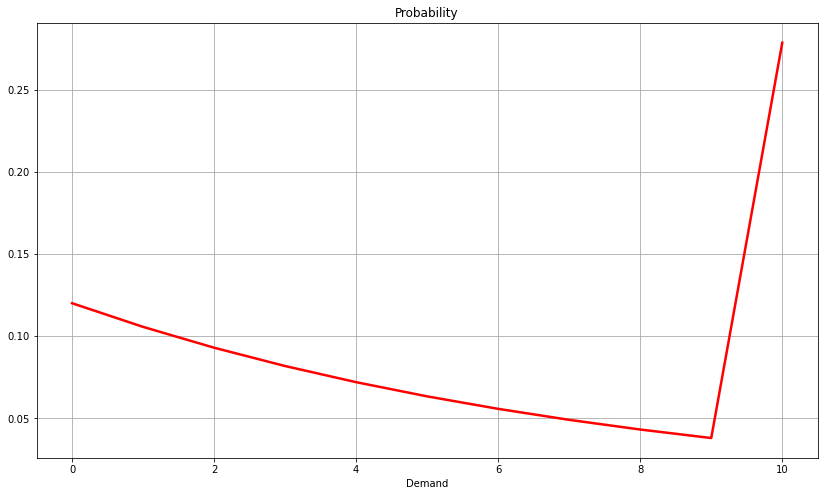

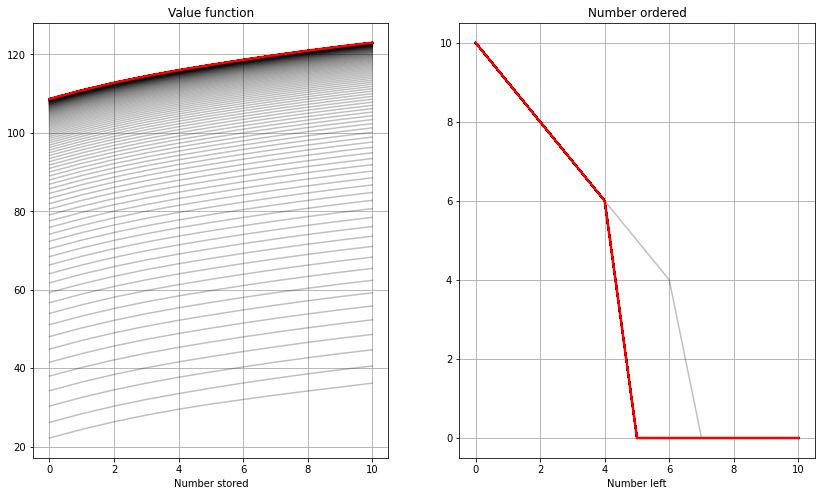

(array([108.64334218, 110.84334218, 112.77934218, 114.48302218,
        115.98226058, 117.34129706, 118.62341005, 119.82912046,
        120.9589457 , 122.01339967, 122.99299277]),
 array([10,  9,  8,  7,  6,  0,  0,  0,  0,  0,  0]))

In [4]:
e = inventory_model('model')
e.plot_pr()
e.solve_show()